Enter the path to the fingerprint image: /content/1.jpg
Encryption key: ExkQ2YnxGJqVApnH7Kwov1srIwXR8k7o7EddgN1G78k=
Encrypted data (in bytes): b'gAAAAABmt5rPmFLooPb-xB_iSdMLWhpfPNameT5wpNtnjnYLg_j-Azu4o9yE4DwifsUh9kRlPu_CkC-JTv2RivUQHe8n0CHqypx9kHwnS4nJd-XgjMjVZSEILwUo9gI-FnrZ55ZyN50yuj4_cdTNuIlw-_G6tDvrf4rgiwg0P9CI2CBIQnLTOLu9wo0aCID0T0QSqmooruJtPs_E7mJMIDiAEcVscNS4lcWOkqtuBYMDoR4xEa6xu3Iifk6ISv8XPX2ydI37oJYB-uMw0Ywq2jTOlJVgN_x-dOwxVUXU8EHEeegmIhWHI9OiH5YhtecHiYbXcSL-jPTCREe8H9J2whXoPx324GCjr9x2n8v_qatjIFdjSNqcFK8GhYUT-NmLF1MOQsyp8VZ7fsKagLKg5SReo2lIVLYnuKrSRf-eMLtfC-LA_PNZGxZeOD2WMs3mpEq5CJp_-HJd2DpcaIM_DiW2DXPKz9HfiS3ZKkAT4qfa46JKoRVMFdEPrUWZQAuaBW7iZFLMSCThqwK3ZR-9Duc8lxTAiCvnHvhkg8_no-8B45TqyfmfNK1mI_c8qI6cwyz4rJt3Cu1kXxFEfNZIZ6e5Kpf7XDHoCYF4stIqfMTYLatAdOAFQmh9sJK2xvGLY6tq0VuPIidLx33pSkrSPceB5CFAlFHLyopAwiazllSBzu_M3yjd3JiwIVwZv0I6u-FatO5B6VGIlJbo_ao3fY8kqnr7eVloj1Pch50-kx7V6ck3mblXJEJjwZnE_1D75zV6oAEiAiNlqbJa1SWtw3ho7SbnC9Lbsp3zbkLlVsswjKs1ybiEN9ZGp8J3x1FHC1KhTMdI7CZB-qJmGl-24G

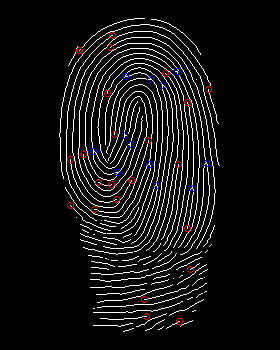

Do you want to save the results? (yes/no): no


In [17]:
import numpy as np
import cv2
import math
from skimage import measure, draw
from skimage.morphology import convex_hull_image, erosion, square
from google.colab.patches import cv2_imshow

class MinutiaeFeature:
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor:
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if minutiaeType.lower() == 'termination':
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if sumVal > 1:
                            angle.append(float('nan'))
            return angle

        elif minutiaeType.lower() == 'bifurcation':
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if (i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0:
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if sumVal != 3:
                angle.append(float('nan'))
            return angle

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if self._skel[i][j] == 1:
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if block_val == 2:
                        self.minutiaeTerm[i, j] = 1
                    elif block_val == 4:
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuring element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1, numPoints):
            for j in range(0, i):
                (X1, Y1) = minutiaeList[i]['centroid']
                (X2, Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2 - X1) ** 2 + (Y2 - Y1) ** 2)
                D[i][j] = dist
                if dist < self._spuriousMinutiaeThresh:
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0, numPoints):
            if not i in SpuriousMin:
                (X, Y) = np.int16(minutiaeList[i]['centroid'])
                img[X, Y] = 1

        img = np.uint8(img)
        return img

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i.centroid))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if len(angle) == 1:
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i.centroid))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if len(angle) == 3:
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return FeaturesTerm, FeaturesBif

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)
        self.__getTerminationBifurcation()
        self.__cleanMinutiae(img)
        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return FeaturesTerm, FeaturesBif

    def showResults(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = draw.circle_perimeter(row, col, 3)
            draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = draw.circle_perimeter(row, col, 3)
            draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        cv2_imshow(DispImg)

    def saveResult(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = draw.circle_perimeter(row, col, 3)
            draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = draw.circle_perimeter(row, col, 3)
            draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        cv2.imwrite('fingerprint_features.png', DispImg)
        print("Results saved to fingerprint_features.png")

def apply_fourier_transform(points):
    if len(points) == 0:
        raise ValueError("No points provided for Fourier Transform")

    N = len(points)
    x_coords = [pt.locX for pt in points]
    y_coords = [pt.locY for pt in points]

    X = np.fft.fft(x_coords)
    Y = np.fft.fft(y_coords)

    return X, Y

def map_to_spherical(X, Y):
    spherical_coords = []
    for x, y in zip(X, Y):
        r = np.sqrt(x.real**2 + y.real**2)
        theta = np.arctan2(y.real, x.real)
        spherical_coords.append((r, theta))
    return spherical_coords

def encrypt_fingerprint(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    feature_extractor = FingerprintFeatureExtractor()
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(image)

    if len(FeaturesTerm) == 0 and len(FeaturesBif) == 0:
        raise ValueError("No features found in the fingerprint image")

    all_points = FeaturesTerm + FeaturesBif
    X, Y = apply_fourier_transform(all_points)
    spherical_coords = map_to_spherical(X, Y)

    # Generate a key for encryption
    key = Fernet.generate_key()
    cipher = Fernet(key)

    # Encrypt the spherical coordinates
    encrypted_data = cipher.encrypt(np.array(spherical_coords, dtype=str).tobytes())

    return key, encrypted_data

import numpy as np
from cryptography.fernet import Fernet

def decrypt_fingerprint(key, encrypted_data):
    cipher = Fernet(key)
    decrypted_data = cipher.decrypt(encrypted_data)

    # Use the appropriate dtype based on how the data was originally encoded
    spherical_coords = np.frombuffer(decrypted_data, dtype=np.float32)  # or dtype=np.float64 if using double precision

    return spherical_coords.tolist()



def decrypt_spherical_coords(spherical_coords):
    cartesian_points = []

    # Ensure spherical_coords has even length (pairs of r and theta)
    if len(spherical_coords) % 2 != 0:
        raise ValueError("Spherical coordinates data is not in pairs of (r, theta).")

    # Convert the flat list into pairs
    for i in range(0, len(spherical_coords), 2):
        r = spherical_coords[i]
        theta = spherical_coords[i + 1]
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        cartesian_points.append((x, y))

    return cartesian_points


def main():
    # Take user input for the image path
    image_path = input("Enter the path to the fingerprint image: ")

    # Encrypt the fingerprint features
    key, encrypted_data = encrypt_fingerprint(image_path)
    print(f"Encryption key: {key.decode()}")  # Display the key to the user
    print(f"Encrypted data (in bytes): {encrypted_data}")

    # Decrypt the fingerprint features
    spherical_coords = decrypt_fingerprint(key, encrypted_data)
    print("Decrypted spherical coordinates:",spherical_coords)
    cartesian_points = decrypt_spherical_coords(spherical_coords)

    print("Decrypted Cartesian points:", cartesian_points)

    # Optionally display or save results
    feature_extractor = FingerprintFeatureExtractor()
    show_result = input("Do you want to display the results? (yes/no): ").strip().lower()
    if show_result == 'yes':
        FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    save_result = input("Do you want to save the results? (yes/no): ").strip().lower()
    if save_result == 'yes':
        FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        feature_extractor.saveResult(FeaturesTerm, FeaturesBif)

if __name__ == "__main__":
    main()
